In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,Bidirectional,GRU,Dense,Dropout
from tensorflow.keras.regularizers import l2
import re
from tensorflow.keras.callbacks import EarlyStopping

In [73]:
df = pd.read_csv('/home/suhas/Desktop/office/Data Science/Notes/Data Analysis/Data/twitter sentiment analysis/twitter_train.csv')

In [74]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [75]:
def preprocess_text(text):
    text = re.sub(r"@\w+|https?://\S+|www\. \S+","",text)
    text = re.sub(r"[^a-zA-Z\s]","",text)
    text = text.lower()
    text = re.sub(r"\s+",' ',text).strip()
    return text

In [76]:
df['cleaned_tweet'] = df['tweet'].apply(preprocess_text)

In [77]:
df.head()

,id,label,tweet,cleaned_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i cant use cause they d...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguide society now motivation


In [78]:
vocab_size = 5000
max_length = 50

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['cleaned_tweet'])

In [79]:
sequences = tokenizer.texts_to_sequences(df['cleaned_tweet'])

In [80]:
padd_sequence = pad_sequences(sequences,maxlen=max_length,padding='post',truncating='post')

In [81]:
X = padd_sequence
y = df['label'].values

In [82]:
X

array([[  33,    3,  253, ...,    0,    0,    0],
       [ 169,    8, 2341, ...,    0,    0,    0],
       [  58,   24, 3199, ...,    0,    0,    0],
       ...,
       [1051,    2,  122, ...,    0,    0,    0],
       [1509, 1282, 1552, ...,    0,    0,    0],
       [ 166,    5,    8, ...,    0,    0,    0]], dtype=int32)

In [83]:
y

array([0, 0, 0, ..., 0, 1, 0])

In [84]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [85]:
X_train

array([[ 152,  226,  115, ...,    0,    0,    0],
       [1624,   26,   49, ...,    0,    0,    0],
       [  89,   89,  172, ...,    0,    0,    0],
       ...,
       [ 203,  173,   55, ...,    0,    0,    0],
       [   9, 1663,  489, ...,    0,    0,    0],
       [  42,  173,   56, ...,    0,    0,    0]], dtype=int32)

In [86]:
model = Sequential([
    Embedding(input_dim=vocab_size,output_dim=100,input_length=max_length),
    Bidirectional(GRU(64)),
    Dropout(0.6),
    Dense(64,activation='relu',kernel_regularizer=l2(0.001)),
    Dropout(0.6),
    Dense(1,activation='sigmoid')
])

In [87]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           500000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               63744     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 572,065
Trainable params: 572,065
Non-trainable params: 0
________________________________________________

In [88]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [89]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True)

In [90]:
history = model.fit(
    X_train,y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test,y_test),
    callbacks = [early_stopping]
)

Epoch 1/15
800/800 [==============================] - 32s 37ms/step - loss: 0.2078 - accuracy: 0.9469 - val_loss: 0.1340 - val_accuracy: 0.9565
Epoch 2/15
800/800 [==============================] - 32s 40ms/step - loss: 0.1061 - accuracy: 0.9681 - val_loss: 0.1429 - val_accuracy: 0.9571
Epoch 3/15
800/800 [==============================] - 28s 35ms/step - loss: 0.0722 - accuracy: 0.9785 - val_loss: 0.1633 - val_accuracy: 0.9562


In [91]:
loss ,accuracy = model.evaluate(X_test,y_test)

print(f"Validation Accuracy:{accuracy}")

200/200 [==============================] - 1s 7ms/step - loss: 0.1340 - accuracy: 0.9565
Validation Accuracy:0.9565149545669556


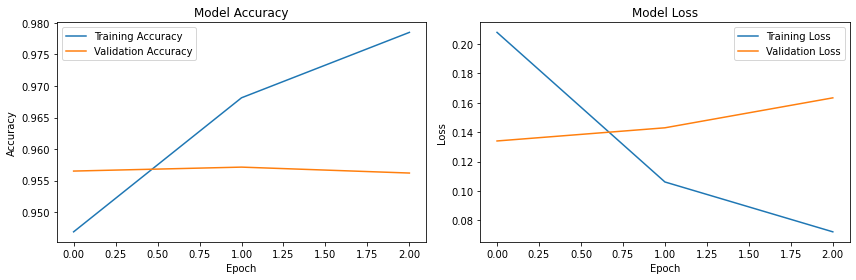

In [93]:
import matplotlib.pyplot as plt
# Visualize training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()